# Kernel Density Map

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Dataset con detalle latitudes y longitudes

In [2]:
df = pd.read_excel('latitud-longitud_detalle.xlsx')

In [3]:
# total de instancias
df.shape[0]

32384

In [4]:
# detalle NaNs
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32384 entries, 0 to 32383
Data columns (total 3 columns):
exp_id          32384 non-null int64
den_latitud     21614 non-null float64
den_longitud    21614 non-null float64
dtypes: float64(2), int64(1)
memory usage: 759.1 KB


In [5]:
# porcentaje not NaNs
df.notna().sum()['den_latitud'] / df.shape[0]

0.6674283596837944

In [6]:
# expedientes repetidos?
print(f'Expedientes repetidos: { df["exp_id"].unique().shape[0] - df.shape[0] }')

Expedientes repetidos: 0


### Comparación Dataset original

In [7]:
# dataset original
penal_df = pd.read_excel('penal_df.xlsx')

In [8]:
# tamaño dataset original
penal_df.shape[0]

37136

In [9]:
# porcentaje not NaNs sobre original
df['den_latitud'].notna().sum() / penal_df.shape[0]

0.5820228349849202

### Mapa CABA

In [10]:
import geopandas as gpd
map_df = gpd.read_file('barrios.csv')
map_df.columns

Index(['WKT', 'barrio', 'comuna', 'perimetro', 'area', 'geometry'], dtype='object')

In [11]:
# Mapa de CABA
from shapely.ops import unary_union
polygons = [map_df.at[i,'geometry'] for i in range(map_df.shape[0])]
caba_polygon = unary_union(polygons)
caba_df = gpd.GeoDataFrame()
caba_df['geometry'] = [caba_polygon]
# Pequeña correcion a la geometría
epsilon = 10**(-12)
caba_df['geometry'] = caba_df['geometry'].map(lambda x:x.buffer(epsilon).buffer(-epsilon))

### Kernel Density Map

In [12]:
from shapely.geometry import Point, Polygon

df_ok = df[df['den_latitud'].notna()].copy()
errores = 0
for i in df_ok.index:
    lat = df_ok.at[i,'den_latitud']
    lon = df_ok.at[i,'den_longitud']
    point_coords = Point(lat,lon)
    if not point_coords.within(caba_polygon):
        df_ok.drop(i,inplace=True)
        errores += 1

print(f'Se removieron { errores } instancias con error.')

Se removieron 891 instancias con error.


In [13]:
# porcentaje de datos validos sobre total original
df_ok['den_latitud'].shape[0] / penal_df.shape[0]

0.5580299439896597

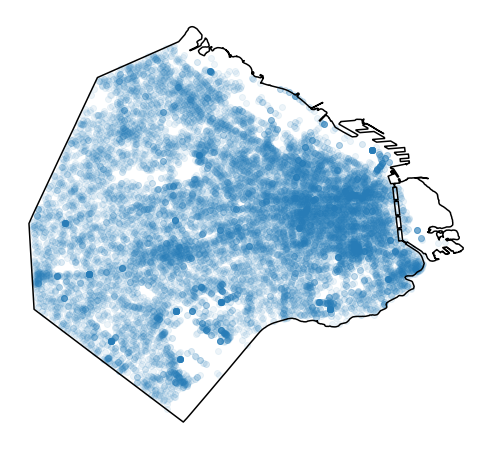

In [14]:
fig, ax = plt.subplots(1, figsize=(10, 8))
caba_df.boundary.plot(ax=ax,edgecolor='0')
plt.scatter(df_ok['den_latitud'],df_ok['den_longitud'],alpha=0.08)
ax.axis('off')
plt.show()

In [15]:
# Creamos polígonos de las Comunas 
# con la función unary union de Shapely
comunas = map_df.comuna.unique()
comunas_geometry = []
for comuna in comunas:
    barrios = [map_df.at[i,'geometry'] for i in range(map_df.shape[0]) if map_df.at[i,'comuna'] == comuna]
    geometry = unary_union(barrios)
    comunas_geometry.append(geometry)

comunas_df = gpd.GeoDataFrame()
comunas_df['Comuna'] = comunas
comunas_df['geometry'] = comunas_geometry
# Corrijo geometría
comunas_df['geometry'] = comunas_df['geometry'].map(lambda x:x.buffer(10**(-12)).buffer(-10**(-12)))
comunas_df['Comuna'] = comunas_df['Comuna'].apply(pd.to_numeric)
comunas_df = comunas_df.sort_values(by='Comuna')

# Agrego una coordenada de cada polígono al geoDataFrame
# esto es para los labels del mapa
comunas_df['coords'] = comunas_df['geometry'].apply(lambda x: x.representative_point().coords[:])
comunas_df['coords'] = [coords[0] for coords in comunas_df['coords']]
comunas_df.head()


,Comuna,geometry,coords
6,1,"POLYGON ((-58.39239 -34.60316, -58.39257 -34.6...","(-58.37920119008943, -34.605895270000005)"
14,2,"POLYGON ((-58.41566 -34.59786, -58.41569 -34.5...","(-58.393353948859556, -34.584020127849996)"
7,3,"POLYGON ((-58.41356 -34.61237, -58.41401 -34.6...","(-58.40227541693436, -34.614390757500004)"
8,4,"POLYGON ((-58.43354 -34.64562, -58.43348 -34.6...","(-58.39171430943253, -34.6399410959)"
2,5,"POLYGON ((-58.43233 -34.60393, -58.43333 -34.6...","(-58.420549629235715, -34.618844705149996)"


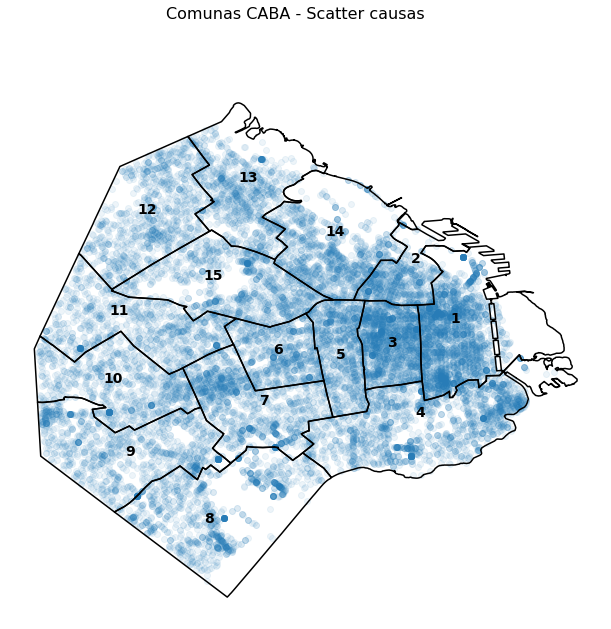

In [16]:
fig, ax = plt.subplots(1, figsize=(12,10))
comunas_df.boundary.plot(ax=ax,edgecolor='0')
# Labeleo el nombre a cada comuna
for idx, row in comunas_df.iterrows():
    plt.annotate(s=row['Comuna'], xy=row['coords'],
                 horizontalalignment='center',size=14,
                weight='bold')
    
plt.scatter(df_ok['den_latitud'],df_ok['den_longitud'],
            alpha=0.08)
ax.axis('off')
fig.suptitle('Comunas CABA - Scatter causas',fontsize=16)
plt.show()

### Utilizando jointplot de seaborn para el kernel density

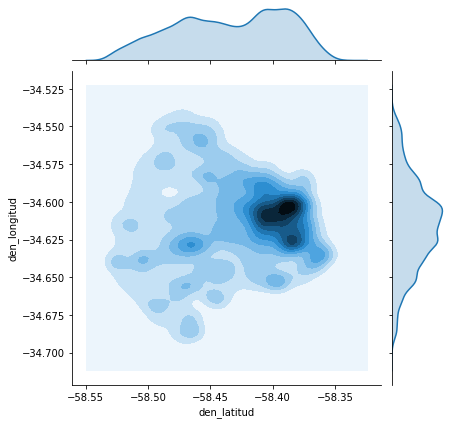

In [47]:
sns.jointplot(x="den_latitud", y="den_longitud", data=df_ok, kind="kde");

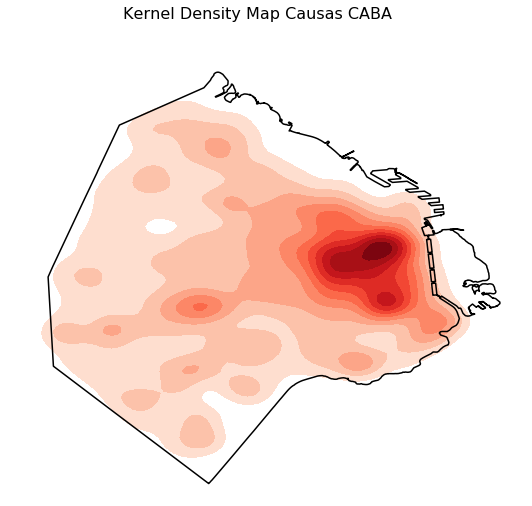

In [39]:
fig, ax = plt.subplots(1, figsize=(10, 8))
caba_df.boundary.plot(ax=ax,edgecolor='0')
kernel_density = sns.jointplot(x="den_latitud",y="den_longitud",
                               data=df_ok, kind="kde",ax=ax,
                               cmap="Reds",shade_lowest=False)
plt.close(kernel_density.fig)
ax.axis('off')
fig.suptitle('Kernel Density Map Causas CABA',fontsize=16)
plt.savefig('kernel_CABA.png')
plt.show()

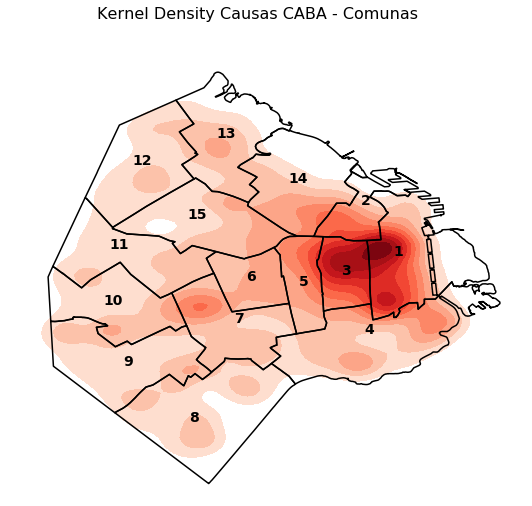

In [44]:
fig, ax = plt.subplots(1, figsize=(10,8))
comunas_df.boundary.plot(ax=ax,edgecolor='0')
# Labeleo el nombre a cada comuna
for idx, row in comunas_df.iterrows():
    plt.annotate(s=row['Comuna'], xy=row['coords'],
                 horizontalalignment='center',size=14,
                weight='bold')

kernel_density = sns.jointplot(x="den_latitud", y="den_longitud",
                               data=df_ok, kind="kde",ax=ax,
                              cmap="Reds",shade_lowest=False)
plt.close(kernel_density.fig)
ax.axis('off')
fig.suptitle('Kernel Density Causas CABA - Comunas',fontsize=16)
plt.savefig('kernel_CABA_Comunas.png')
plt.show()